#### Torch CNN - CIFAR10

In [ ]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

BATCH_SIZE = 128
DOWNLOAD = False
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='../data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='../data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f"Using a subset of {SUBSET} samples for training and testing.")
else:
    train_set, test_set = train_dataset, test_dataset
    print("Using the full dataset for training and testing.")

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [2]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    if n_step < 1.5:
        n_step = str(n_step).replace('.', '')

    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step,
    }
    with open(f'{save_path}/SGD_lr_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)
    

In [3]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval() 
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    with torch.no_grad(): 
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [4]:
import os, json

def viz_scores(scores_path, threshold):
    contents = os.walk(scores_path)
    lr_runtime, lr_epochs, runtimes, epochs, lrs = {}, {}, [], [], []
    train_loss_dict = {}
    train_acc_dict = {}

    for root, dirs, files in contents:
        for f in files:
            if f.startswith("SGD_lr"):
                _path = os.path.join(root, f)
                with open(_path, 'r') as file:
                    data = json.load(file)
                lrs.append(float(data['n_step'][0] + '.' + data['n_step'][1:]))
                runtimes.append(sum(data['run_time']))
                epochs.append(len(data['run_time']))

                train_loss_dict[data['n_step']] = data['train_losses']
                train_acc_dict[data['n_step']] = data['train_accs']
    lr_runtime['lr'] = lrs
    lr_runtime['run_time'] = runtimes
    lr_epochs['lr'] = lrs
    lr_epochs['nepochs'] = epochs
    
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.plot(lr_runtime['lr'], lr_runtime['run_time'], label='Runtime', marker='o',linestyle='', color='blue', alpha=.5)
    ax2.plot(lr_epochs['lr'], lr_epochs['nepochs'], label='Epochs', marker='o', linestyle='', color='red', alpha=.5)

    ax1.set_ylabel('Runtime (s)')
    ax2.set_ylabel('Epochs')

    ax1.set_xlabel('Stepsize')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    plt.title(f'Step size evaluation to get {threshold}% train acc')
    plt.grid(True)
    plt.show()
    return train_loss_dict, train_acc_dict

In [ ]:
import os, sys
from pathlib import Path

sys.path.append(str(Path('.ipynb').resolve().parents[1]))

from models import SimpleCNN
from optim.sgd_sngl import OneStepSGD
from optim.sgd_mult import ManyStepSGD
import time 

def modeling(n_step=2, n_epochs=15, lr=0.133, momentum=0, threshold=90):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()

    if n_step == 1:
        optimizer = OneStepSGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer = ManyStepSGD(model.parameters(), lr=lr, momentum=momentum, n_step=n_step)

    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []
    
    def closure():
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        return loss
    
    for i, epoch in enumerate(range(n_epochs)):
#         print(f"Epoch: {i+1}/{n_epochs}")
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward
            outputs = model(images)
            
            # Backward
            loss = optimizer.step(closure)

            running_loss += loss.item()
            # Training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        run_time = time.time() - _start

        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)
        
        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {run_time}')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train acc {epoch_train_acc:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

In [19]:
from plot import metrics_plot
n_epochs = 30
n_step = 8
lrs = [0.133]
threshold = 95

for lr in lrs:
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_step=n_step, 
                                                                                       n_epochs=n_epochs, 
                                                                                       lr=lr,
                                                                                       threshold=threshold,
                                                                                      )
    save_path = 'scores/E30T95'
    save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step=lr,
                     )
    actual_nepochs = len(train_losses)
#     metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

E [1/30]. train_loss_acc: 0.1051, 48.55%, test_acc: 61.68%, run_time: 13.008180379867554
E [2/30]. train_loss_acc: 0.0143, 63.63%, test_acc: 69.16%, run_time: 12.759678602218628
E [3/30]. train_loss_acc: 0.0119, 68.93%, test_acc: 71.57%, run_time: 12.758200645446777
E [4/30]. train_loss_acc: 0.0104, 72.40%, test_acc: 74.27%, run_time: 12.658004999160767
E [5/30]. train_loss_acc: 0.0094, 74.70%, test_acc: 76.06%, run_time: 12.728891372680664
E [6/30]. train_loss_acc: 0.0087, 76.51%, test_acc: 77.18%, run_time: 12.763652086257935
E [7/30]. train_loss_acc: 0.0080, 77.86%, test_acc: 77.64%, run_time: 13.056431293487549
E [8/30]. train_loss_acc: 0.0072, 79.83%, test_acc: 78.04%, run_time: 13.031469345092773
E [9/30]. train_loss_acc: 0.0069, 80.60%, test_acc: 78.62%, run_time: 13.085393190383911
E [10/30]. train_loss_acc: 0.0064, 81.72%, test_acc: 78.63%, run_time: 13.139185428619385
E [11/30]. train_loss_acc: 0.0059, 82.49%, test_acc: 80.11%, run_time: 13.077881813049316
E [12/30]. train_lo

In [ ]:
scores_path_1 = "scores/E20T60"
train_loss_dict_1, train_acc_dict_1 = viz_scores(scores_path_1, threshold=60)
scores_path_2 = "scores/E30T90"
train_loss_dict_2, train_acc_dict_2 = viz_scores(scores_path_2, threshold=80)

## Compare Single vs Multi Descent Steps SGD

dict_keys(['train_losses', 'test_losses', 'train_errs', 'test_errs', 'train_accs', 'test_acc', 'run_time', 'n_step'])


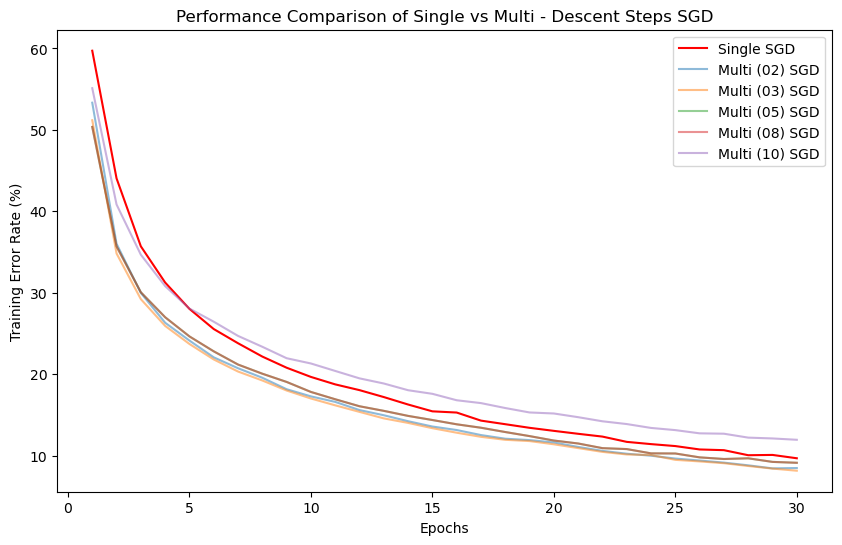

In [22]:
import json
import matplotlib.pyplot as plt

sngl_sgd = "optimal_step_size/scores/E30T95/SGD_lr_0133_sngl.json"
mult_02_sgd = "optimal_step_size/scores/E30T95/SGD_lr_0133_mult_02.json"
mult_03_sgd = "optimal_step_size/scores/E30T95/SGD_lr_0133_mult_03.json"
mult_05_sgd = "optimal_step_size/scores/E30T95/SGD_lr_0133_mult_05.json"
mult_08_sgd = "optimal_step_size/scores/E30T95/SGD_lr_0133_mult_08.json"
mult_10_sgd = "optimal_step_size/scores/E30T95/SGD_lr_0133_mult_10.json"

with open(sngl_sgd, 'r') as f:
    sngl_scores = json.load(f)
with open(mult_02_sgd, 'r') as f:
    mult_02_scores = json.load(f)
with open(mult_03_sgd, 'r') as f:
    mult_03_scores = json.load(f)
with open(mult_05_sgd, 'r') as f:
    mult_05_scores = json.load(f)
with open(mult_08_sgd, 'r') as f:
    mult_08_scores = json.load(f)
with open(mult_10_sgd, 'r') as f:
    mult_10_scores = json.load(f)

print(sngl_scores.keys())
plt.figure(figsize=(10,6))
plt.plot(range(1, len(sngl_scores['train_errs'][:30])+1), sngl_scores['train_errs'][:30], linestyle='-', label='Single SGD', color='red')
plt.plot(range(1, len(mult_02_scores['train_errs'])+1), mult_02_scores['train_errs'], linestyle='-', label='Multi (02) SGD', alpha=.5)
plt.plot(range(1, len(mult_03_scores['train_errs'])+1), mult_03_scores['train_errs'], linestyle='-', label='Multi (03) SGD', alpha=.5)
plt.plot(range(1, len(mult_05_scores['train_errs'])+1), mult_05_scores['train_errs'], linestyle='-', label='Multi (05) SGD', alpha=.5)
plt.plot(range(1, len(mult_08_scores['train_errs'])+1), mult_05_scores['train_errs'], linestyle='-', label='Multi (08) SGD', alpha=.5)
plt.plot(range(1, len(mult_10_scores['train_errs'])+1), mult_10_scores['train_errs'], linestyle='-', label='Multi (10) SGD', alpha=.5)
plt.xlabel('Epochs')
plt.ylabel('Training Error Rate (%)')
plt.title('Performance Comparison of Single vs Multi - Descent Steps SGD')
plt.legend()
plt.show()